In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import mt4_hst
from stock_env.feature.feature_extractor import TrendFeatures

# Create your own Custom Strategy
TrendStrategy = ta.Strategy(
    name="Trend Signal Strategy",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "percent_return", "length": 1},
        {"kind": "sma", "length": 50},
        {"kind": "ema", "length": 10},
        {"kind": "ema", "length": 20},
        {"kind": "donchian", "lower_length": 10, "upper_length": 10},
        {"kind": "donchian", "lower_length": 20, "upper_length": 20},
        {"kind": "donchian", "lower_length": 50, "upper_length": 50},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
    ]
)

In [2]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("seaborn") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015 # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

In [3]:
# v2
def trends(df: pd.DataFrame):
    # create neccesary indicators
    df.ta.strategy(TrendStrategy)
    
    # condition
    trend_cond = (
        (df['close'] > df['SMA_50']).astype(int)
        + (df['EMA_10'] > df['EMA_20']).astype(int)
        + (df['DCL_10_10'] > df['DCL_50_50']).astype(int)
    ) >= 2
    
    return trend_cond

def trends_confirm_entries(df: pd.DataFrame):
    volume_breakout = (df['volume'] >= 1.25 * df['VOLUME_SMA_20']).astype(int)
    
    # candle pattern
    entry_pattern = df.ta.cdl_pattern(
        name=["closingmarubozu", "marubozu", "engulfing", "longline"], 
        scalar=1).sum(axis=1).astype(int)
    
    exit_pattern = df.ta.cdl_pattern(
        name=["closingmarubozu", "marubozu", "engulfing", "longline"], 
        scalar=1).sum(axis=1).astype(int)
    
    df['entry'] = (
        (entry_pattern > 0) 
        * volume_breakout 
        * (df['close'] > df['DCU_10_10'].shift())
    ).astype(bool).astype(int)
    
    df['exit'] = (
        (exit_pattern < 0) 
        * volume_breakout 
        # * (df['close'] < df['DCL_10_10'].shift())
    ).astype(bool).astype(int)
    
    def modify_entry_exit(df):
        df['trends_'] = np.nan
        
        try:
            entry_idx = df[df['entry'] == 1].index[0]
            df['trends_'].loc[entry_idx] = 1
            
            try:
                exit_idx = df[df['exit'] == 1].index[-1]
                if entry_idx <= exit_idx:
                    df['trends_'].loc[exit_idx] = 1
            except:
                pass
            finally:
                df['trends_'] = df['trends_'].ffill()
        except IndexError:
            df['trends_'] = df['trends_'].fillna(0)
        
        try:
            df['trends_'] = df['trends_'].interpolate(limit_area='inside', method='nearest')
        except ValueError:
            df['trends_'] = df['trends_'].fillna(0)
        return df['trends_'].fillna(0) * df['trends']

    df['original_trends'] = df['trends']
    df['trends'] = df.groupby((df.trends != df.trends.shift()).cumsum()).apply(modify_entry_exit).to_list()
    return df

In [17]:
ticker = 'FPT'
benchmark = 'VNINDEX'
# df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")

benchmark = mt4_hst.read_hst("../stock_datasets/" + benchmark + "1440.hst")
benchmark = benchmark[['time', 'close']].rename(columns={'close': 'benchmark'})
df = mt4_hst.read_hst("../stock_datasets/" + ticker + "1440.hst")
df = df.merge(benchmark, how='inner', on='time')
df.index = df['time']
df = TrendFeatures().preprocess(df, asbool=True, return_all=True)
# df.to_csv('temp/signal/' + ticker + '.csv', index=False)

ValueError: 'time' is both an index level and a column label, which is ambiguous.

# Backtest

In [9]:
from stock_env.utils import create_performance

# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=df.TS_Entries,
    exits=df.TS_Exits,
)
assetpf_signals.stats(settings=dict(benchmark_rets=df.benchmark.pct_change()))

Start                         2007-03-01 00:00:00
End                           2022-08-10 00:00:00
Period                                       3850
Start Value                                 100.0
End Value                              835.760321
Total Return [%]                       735.760321
Benchmark Return [%]                    11.804257
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         40.84169
Max Drawdown Duration                       636.0
Total Trades                                   30
Total Closed Trades                            30
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            63.333333
Best Trade [%]                          54.991953
Worst Trade [%]                         -7.692309
Avg Winning Trade [%]                   15.340985
Avg Losing Trade [%]                    -3.810763



    Annual return     :  14.91%
    Cumulative return :  735.76%
    Sharpe ratio      :  0.85
    Maximum Drawdown  : -40.84%
    Annual Volatility :  18.43%
    Value-At-Risk     :  nan%
    


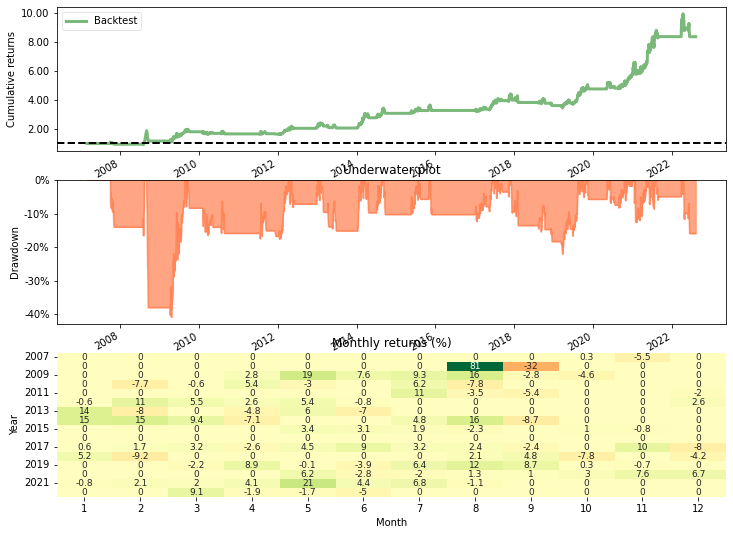

In [10]:
values = assetpf_signals.value()
values.index = df['time']
returns = values.pct_change()
create_performance(returns)

In [11]:
fig = df.close.vbt.plot(trace_kwargs=dict(name=ticker), autosize=False,width=1000,height=500)
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'FPT',
              'showlegend': True,
              'type': 'scatter',…

In [16]:
values.loc['2008-09-03':'2008-09-20']

time
2008-09-03    179.722095
2008-09-04    188.212915
2008-09-05    179.722095
2008-09-08    171.231297
2008-09-09    162.740488
2008-09-10    155.664815
2008-09-11    148.589143
2008-09-12    141.513459
2008-09-15    135.145355
2008-09-16    128.777251
2008-09-17    122.409147
2008-09-18    116.748611
2008-09-19    116.748611
dtype: float64

In [13]:
values.vbt.drawdowns.plot(top_n=3)

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'showlegend': False,
              't…